# Unscented Kalman Filter
<a href="https://colab.research.google.com/github/LinkHS/Colab/blob/main/Kalmanfilter/unscented_kalman_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import scipy.linalg

# Python Robotics
## States and Control inputs

状态量：x坐标、y坐标、偏航角、速度
> $x$, $y$ are a 2D x-y position, $\phi$ is orientation, and $v$ is velocity.

$\textbf{x}_t=[x_t, y_t, \phi_t, v_t]$


控制量：速度、角速度
> The robot has a speed sensor and a gyro sensor.

$\textbf{u}_t=[v_t, \omega_t]$


In [2]:
def calc_input():
  v = 1.0  # [m/s]
  yawRate = 0.1  # [rad/s]
  u = np.array([[v, yawRate]]).T
  return u

u = calc_input()
u

array([[1. ],
       [0.1]])

## Motion Model
The robot model is 

$ \dot{x} = vcos(\phi)$  
$ \dot{y} = vsin((\phi)$  
$ \dot{\phi} = \omega$

Given that $\textbf{x}_t = [x_t, y_t, \phi_t, v_t]$，$\textbf{u}_t = [v_t, \dot{\phi}]$

the motion model is

$\textbf{x}_{t+1} = f(x_t, u_t)$  
$\qquad = F\textbf{x}_t+B\textbf{u}_t$

 
$x_{t+1} = x_t + \dot{x}\Delta t$  
$y_{t+1} = y_t + \dot{y}\Delta t$  
$\phi_{t+1} = \phi_t + \dot{\phi}\Delta t$  
$v_{t+1} = 0 + v_{t+1}$

where

$\begin{equation*}
F=
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
B=
\begin{bmatrix}
cos(\phi)\Delta t & 0\\
sin(\phi)\Delta t & 0\\
0 & \Delta t\\
1 & 0\\
\end{bmatrix}
\end{equation*}$


In [3]:
def motion_model(x, u, dt):
  F = np.array([[1.0, 0, 0, 0],
          [0, 1.0, 0, 0],
          [0, 0, 1.0, 0],
          [0, 0, 0, 0]])

  B = np.array([[dt * math.cos(x[2]), 0],
          [dt * math.sin(x[2]), 0],
          [0.0, dt],
          [1.0, 0.0]])
  x = F@x + B@u
  return x

## Observation Model
观测量：x坐标、y坐标
> The robot has a GNSS sensor.

$\textbf{z}_t = [x_t, y_t]$

Given that $\textbf{x}_t = [x_t, y_t, \phi_t, v_t]$, so the observation model is

$\textbf{z}_{t} = H\textbf{x}_t$

where

$\begin{equation*}
H=
\begin{bmatrix}
1 & 0 & 0& 0\\
0 & 1 & 0& 0\\
\end{bmatrix}
\end{equation*}$


In [4]:
def observation_model(x):
  H = np.array([[1, 0, 0, 0],
          [0, 1, 0, 0]])
  z = H @ x
  return z

x = np.ones((4, 1))
observation_model(x)

array([[1.],
       [1.]])

给观测量和控制量加上噪音：

$\textbf{u}_d = \textbf{u} + \epsilon$

$\textbf{z} = H\textbf{x} + \delta$

In [5]:
# Simulation parameter
INPUT_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.5, 0.5]) ** 2

def observation(xTrue, u, dt):
  xTrue = motion_model(xTrue, u, dt)
  # add noise to gps x-y
  z = observation_model(xTrue) + GPS_NOISE @ np.random.randn(2, 1)
  # add noise to input
  ud = u + INPUT_NOISE @ np.random.randn(2, 1)
  return xTrue, z, ud

xTrue = np.zeros((4, 1))
u = calc_input()
xTrue, z, ud = observation(xTrue, u, dt=1)
print('xTrue:\n', xTrue)
print('\nz:\n', z)
print('\nu:\n', u)
print('\nu with noise:\n', ud)

xTrue:
 [[1. ]
 [0. ]
 [0.1]
 [1. ]]

z:
 [[ 1.22539845]
 [-0.11166166]]

u:
 [[1. ]
 [0.1]]

u with noise:
 [[0.3668484 ]
 [0.23745866]]


## Sigma points
In this case, the functions $f$ and $h$ are not linear. UKF applies UT to performs the approximation with extracted points called ”Sigma points. Sigma points are computed using the matrix $S$ which is defined from the covariance matrix, $\Sigma_t$. $S_i$ denotes the i-th colum of the matrix $S$

$$S = \sqrt{\Sigma_t}$$

We define the sigma points $X_{i,t} \in X_t$ as follows:

$$
X_{i, t}=\left\{\begin{array}{ll}
=\mu_{t}, & i=0 \\
=\mu_{t}+\gamma S_{i}, & i=1, \ldots, N \\
=\mu_{t}-\gamma S_{i-N}, & i=N+1, \ldots, 2 N
\end{array}\right.
$$

where $N$ is the dimension of the state, and $\gamma$ is computed by:

$$\gamma = \sqrt{N+\lambda}$$

$$\lambda = \alpha^{2}(N+\kappa) - N$$

$\alpha, \kappa$ are two hyper-parameters (scaling parameters) of UKF.


In [6]:
def generate_sigma_points(xEst, PEst, gamma):
  sigma = xEst
  Psqrt = scipy.linalg.sqrtm(PEst) # PEst = Psqrt @ Psqrt
  n = len(xEst[:, 0])
  # Positive direction
  for i in range(n):
    sigma = np.hstack((sigma, xEst + gamma*Psqrt[:, i:i+1]))

  # Negative direction
  for i in range(n):
    sigma = np.hstack((sigma, xEst - gamma*Psqrt[:, i:i+1]))
  return sigma

N = 4
ALPHA = 0.001
KAPPA = 0

lambda_ = ALPHA ** 2 * (N + KAPPA) - N
gamma = math.sqrt(N + lambda_)

xEst = np.zeros((N, 1))
xTrue = np.zeros((N, 1))
PEst = np.eye(N)
sigma_points = generate_sigma_points(xEst, PEst, gamma)
sigma_points.shape # (N, 2N+1)

(4, 9)

## Predication
And then, the sigma points are passed through the nonlinear function $f$:

$$\bar{X} = f(X)$$

In [7]:
def predict_sigma_motion(sigma, u, dt):
  """
    Sigma Points prediction with motion model
  """
  for i in range(sigma.shape[1]):
    sigma[:, i:i+1] = motion_model(sigma[:, i:i+1], u, dt)
  return sigma

u = calc_input()
perdicted_points = predict_sigma_motion(sigma_points, u, 1)
perdicted_points.shape

(4, 9)

Here $\bar{X}$ are transformed sigma points. Finally, the objective parameters $\mu'$ and $\Sigma'$ of resultant Gaussian are calculated using the unscented transform on the tranformed sigma points, $\mu', \Sigma^\ =\ UT(\bar{X}, \omega_m, \omega_c, Q)$:

$$\mu^{\prime} = \sum_{i=0}^{2n} \omega_i^m \bar{X}_i$$

$$\Sigma^{\prime} = \sum_{i=0}^{2n} \omega_i^c \left(\bar{X}_i-\mu^{\prime}\right)\left(\bar{X}_i-\mu^{\prime}\right)^{T} + Q$$

where $Q$ is Transition model convariance;

and $\omega^m$ are weights used when the mean is computed:

$$
w_i^m=\left\{\begin{array}{ll} 
& =\frac{\lambda}{N+\lambda} & i=0 \\
& =\frac{1}{2(N+\lambda)}, & i=1, \ldots, 2 N \end{array}\right.
$$

and $\omega^c$ are weights used when the covariance of Gaussian is recovered:

$$
w^c_i=\left\{\begin{aligned}
&=\frac{\lambda}{N+\lambda}+\left(1-\alpha^{2}+\beta\right) & i=0 \\
&=\frac{1}{2(N+\lambda)}, & i=1, \ldots, 2 N
\end{aligned}\right.
$$

In [8]:
# UKF Parameter
ALPHA = 0.001
BETA = 2
KAPPA = 0

# calculate weights
wm = [lambda_ / (lambda_ + N)]
wc = [(lambda_ / (lambda_ + N)) + (1 - ALPHA**2 + BETA)]
for i in range(2*N):
  wm.append(1.0 / (2*(N + lambda_)))
  wc.append(1.0 / (2*(N + lambda_)))

wm = np.array([wm])
wc = np.array([wc])
wm.shape, wc.shape

((1, 9), (1, 9))

Recall that:

$\mu^{\prime} = \sum_{i=0}^{2n} \omega_{m}^{[i]} \bar{X}^{[i]}$

$\Sigma^{\prime} = \sum_{i=0}^{2n} \omega_{c}^{[i]}\left(\bar{X}^{[i]}-\mu^{\prime}\right)\left(\bar{X}^{[i]}-\mu^{\prime}\right)^{T}$


In [9]:
# Covariance for UKF simulation
Q = np.diag([
    0.1,  # variance of location on x-axis
    0.1,  # variance of location on y-axis
    np.deg2rad(1.0),  # variance of yaw angle
    1.0  # variance of velocity
]) ** 2  # predict state covariance

def calc_sigma_covariance(x, sigma, wc, Pi):
  nSigma = sigma.shape[1]
  d = sigma - x[0:sigma.shape[0]]
  P = Pi
  for i in range(nSigma):
    P = P + wc[0, i] * d[:, i:i+1] @ d[:, i:i+1].T
  return P

xPred = (wm @ perdicted_points.T).T
PPred = calc_sigma_covariance(xPred, perdicted_points, wc, Q)
xPred.shape, PPred.shape

((4, 1), (4, 4))

## Update
Kalman filters perform the update in measurement space. Thus we must convert the sigma points of the prior into measurements using the measurement function  $h$:

$$
Z = h(\bar{X})
$$

Then we compute the mean and covariance of these points using the unscented transform, $\mu_z, P_z = UT(Z, w_m, w_c, R)$.
> The $z$ subscript denotes that these are the mean and covariance of the measurement sigma points.)

$$\begin{aligned}
\mu_z &= \sum_{i=0}^{2n} w^m_i Z_i \\
P_z &= \sum_{i=0}^{2n} w^c_i{(Z_i-\mu_z)(Z_i-\mu_z)^\mathsf T} + R
\end{aligned}
$$

where $R$ is Measurement model covariance.

In [10]:
# Update
R = np.diag([1.0, 1.0]) ** 2  # Observation x,y position covariance

zSigmaPoints = observation_model(perdicted_points)
mu_z = (wm @ zSigmaPoints.T).T
P_z = calc_sigma_covariance(mu_z, zSigmaPoints, wc, R)

mu_z.shape, P_z.shape

((2, 1), (2, 2))

Next we compute the residual and Kalman gain. The residual of the measurement $z$ is trivial to compute:

$$y = \mathbf z_m - \mu_z$$

To compute the Kalman gain we first compute the [cross covariance](https://en.wikipedia.org/wiki/Cross-covariance) of the state and the measurements, which is defined as: 

$$P_{xz} = \sum_{i=0}^{2n} w^c_i(\bar{X}_i - \mu')(Z_i - \mu_z)^\mathsf T$$

And then the Kalman gain is defined as

$$K = P_{xz}P^{-1}_z$$

If you think of the inverse as a *kind of* matrix reciprocal, you can see that the Kalman gain is a simple ratio which computes:

$$K \approx \frac{P_{xz}}{P_z} 
\approx \frac{\text{belief in state}}{\text{belief in measurement}}$$


In [11]:
def calc_pxz(sigma, x, z_sigma, zb, wc):
  nSigma = sigma.shape[1]
  dx = sigma - x
  dz = z_sigma - zb[0:2]
  P = np.zeros((dx.shape[0], dz.shape[0]))

  for i in range(nSigma):
    P = P + wc[0, i] * dx[:, i:i+1] @ dz[:, i:i+1].T
  return P

y = z - mu_z
Pxz = calc_pxz(perdicted_points, xPred, zSigmaPoints, mu_z, wc)
K = Pxz @ np.linalg.inv(P_z)
y.shape, Pxz.shape, K.shape

((2, 1), (4, 2), (4, 2))

Finally, we compute the new state estimate using the residual and Kalman gain:

$$\mathbf x = \mu' + Ky$$

and the new covariance is computed as:

$$
\mathbf P = \Sigma' - KP_zK^{\mathsf T}
$$

In [12]:
xEst = xPred + K @ y
PEst = PPred - K @ P_z @ K.T

xEst.shape, PEst.shape

((4, 1), (4, 4))

In [13]:
xTrue, xEst

(array([[0.],
        [0.],
        [0.],
        [0.]]), array([[ 0.93523919],
        [-0.07444109],
        [ 0.06277945],
        [ 1.        ]]))

## Sum-up
This table compares the equations of the linear KF and UKF equations.

$$\begin{array}{l|l}
\textrm{Kalman Filter} & \textrm{Unscented Kalman Filter} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T+\mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q \\
\hline 
& \boldsymbol{\mathcal Z} =  h(\boldsymbol{\mathcal{Y}}) \\
& \boldsymbol\mu_z = \sum w^m\boldsymbol{\mathcal{Z}} \\
\mathbf y = \mathbf z - \mathbf{Hx} &
\mathbf y = \mathbf z - \boldsymbol\mu_z \\
\mathbf S = \mathbf{H\bar PH}^\mathsf{T} + \mathbf R & 
\mathbf P_z = \sum w^c{(\boldsymbol{\mathcal Z}-\boldsymbol\mu_z)(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}} + \mathbf R \\ 
\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf S^{-1} &
\mathbf K = \left[\sum w^c(\boldsymbol{\mathcal Y}-\bar{\mathbf x})(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}\right] \mathbf P_z^{-1} \\
\mathbf x = \mathbf{\bar x} + \mathbf{Ky} & \mathbf x = \mathbf{\bar x} + \mathbf{Ky}\\
\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P} & \mathbf P = \bar{\mathbf P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}
\end{array}$$

In [14]:
def ukf_estimation(xEst, PEst, z, u, wm, wc, gamma, dt):
  # Predict
  sigma = generate_sigma_points(xEst, PEst, gamma)
  perdicted_points = predict_sigma_motion(sigma, u, dt)
  xPred = (wm @ sigma.T).T
  PPred = calc_sigma_covariance(xPred, sigma, wc, Q)

  # Update
  zSigmaPoints = observation_model(sigma)
  mu_z = (wm @ zSigmaPoints.T).T
  P_z = calc_sigma_covariance(mu_z, zSigmaPoints, wc, R)
  Pxz = calc_pxz(perdicted_points, xPred, zSigmaPoints, mu_z, wc)
  K = Pxz @ np.linalg.inv(P_z)
  y = z - mu_z
  xEst = xPred + K @ y
  PEst = PPred - K @ P_z @ K.T

  return xEst, PEst

def setup_ukf(nx, ALPHA, BETA, KAPPA):
  lamb = ALPHA ** 2 * (nx + KAPPA) - nx
  # calculate weights
  wm = [lamb / (lamb + nx)]
  wc = [(lamb / (lamb + nx)) + (1 - ALPHA ** 2 + BETA)]
  for i in range(2 * nx):
      wm.append(1.0 / (2 * (nx + lamb)))
      wc.append(1.0 / (2 * (nx + lamb)))
  gamma = math.sqrt(nx + lamb)

  wm = np.array([wm])
  wc = np.array([wc])

  return wm, wc, gamma

In [15]:
def plot_covariance_ellipse(xEst, PEst):  # pragma: no cover
  Pxy = PEst[0:2, 0:2]
  eigval, eigvec = np.linalg.eig(Pxy)

  if eigval[0] >= eigval[1]:
    bigind = 0
    smallind = 1
  else:
    bigind = 1
    smallind = 0

  t = np.arange(0, 2 * math.pi + 0.1, 0.1)
  a = math.sqrt(eigval[bigind])
  b = math.sqrt(eigval[smallind])
  x = [a * math.cos(it) for it in t]
  y = [b * math.sin(it) for it in t]
  angle = math.atan2(eigvec[1, bigind], eigvec[0, bigind])
  rot = Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]
  fx = rot @ np.array([x, y])
  px = np.array(fx[0, :] + xEst[0, 0]).flatten()
  py = np.array(fx[1, :] + xEst[1, 0]).flatten()
  plt.plot(px, py, "--r")

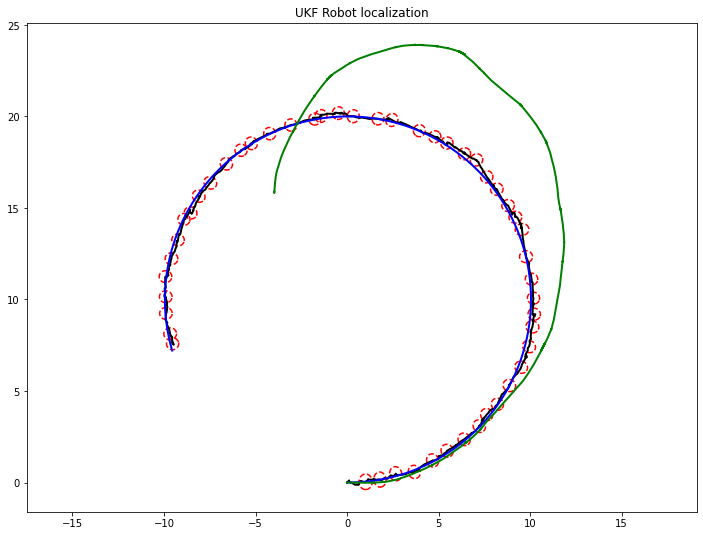

In [16]:
DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

# Covariance for UKF simulation
Q = np.diag([
    0.1,  # variance of location on x-axis
    0.1,  # variance of location on y-axis
    np.deg2rad(1.0),  # variance of yaw angle
    1.0  # variance of velocity
]) ** 2  # predict state covariance
R = np.diag([1.0, 1.0]) ** 2  # Observation x,y position covariance

# UKF Parameter
ALPHA = 0.001
BETA = 2
KAPPA = 0

def main():
  nx = 4  # State Vector [x y yaw v]'
  xEst = np.zeros((nx, 1))
  xTrue = np.zeros((nx, 1))
  PEst = np.eye(nx)
  xDR = np.zeros((nx, 1))  # Dead reckoning

  wm, wc, gamma = setup_ukf(nx, ALPHA, BETA, KAPPA)

  # history
  hxEst = xEst
  hxTrue = xTrue
  hxDR = xTrue
  hz = np.zeros((2, 1))

  plt.figure(figsize=(12,9))
  time = 0.0
  while SIM_TIME >= time:
    time += DT
    u = calc_input()

    xTrue, z, ud = observation(xTrue, u, DT)
    xDR = motion_model(xDR, ud, DT)

    xEst, PEst = ukf_estimation(xEst, PEst, z, ud, wm, wc, gamma, dt=DT)

    # store data history
    hxEst = np.hstack((hxEst, xEst))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hz = np.hstack((hz, z))
    if (int(time*10) % 10) == 0:
      plot_covariance_ellipse(xEst, PEst)

  plt.plot(hxEst[0, :], hxEst[1, :], color='k', lw=2)
  plt.plot(hxTrue[0, :], hxTrue[1, :], color='b', lw=2)
  plt.plot(hxDR[0, :], hxDR[1, :], color='g', lw=2)

  plt.axis('equal')
  plt.title("UKF Robot localization")
  plt.show()

main()

## cholesky VS sqrtm


### 正定矩阵 & 半正定矩阵
对于任意长度的非零向量$X$，若：
- $X^TAX > 0$，则矩阵$A$为正定矩阵
- $X^TAX \ge 0$，则矩阵$A$为半正定矩阵

记转换后的向量$M = AX$，则$X^TAX = X^TM = \cos(\theta)\cdot ||M||\cdot||X||$，那么意味着：
- 对于正定矩阵，$\cos(\theta) > 0$，即$\theta < 90^{\circ}$
- 对于半正定举证，$\cos(\theta) \ge 0$，即$\theta \le 90^{\circ}$

矩阵变换$AX$表示向量$X$会沿着该矩阵特征向量的方向进行变换（缩放），缩放比例由特征值$\lambda$决定。从特征值角度来看：
- 正定矩阵所有特征值都大于0
- 半正定矩阵所有特征值大于等于0

那么正定矩阵小于90度的含义是变换后的向量$M$是沿着原向量$X$的正方向进行缩放的（即$M$投影回原向量时方向不变）。

参考资料：
- [矩阵的特征值是虚数，它的几何解释是什么？](https://www.zhihu.com/question/319276709/answer/1195620832)
- [如何理解正定矩阵和半正定矩阵](https://www.cnblogs.com/marsggbo/p/11461155.html)
- 为什么协方差矩阵要是半正定的？[浅谈「正定矩阵」和「半正定矩阵」](https://zhuanlan.zhihu.com/p/44860862)

### cholesky分解
Cholesky 分解是把一个对称正定的矩阵表示成一个下三角矩阵L和其转置的乘积的分解$A = L L^T$。它要求矩阵的所有特征值必须大于零，故分解的下三角的对角元也是大于零的。

In [17]:
A = np.array([[1, 0, 0],
        [1, 1, 1],
        [2, 1, 1]])

np.linalg.eig(A)[0]

array([2., 0., 1.])

由于$A$的特征值有0（半正定），所以不能用Cholesky分解，这里用`sqrtm`：

In [18]:
scipy.linalg.sqrtm(A) @ scipy.linalg.sqrtm(A)

array([[1., 0., 0.],
       [1., 1., 1.],
       [2., 1., 1.]])

再看下对称正定矩阵：


In [19]:
B = np.array([[6, -3, 1],
        [-3, 2, 0],
        [1, 0, 4]])

np.linalg.eig(B)[0]

array([7.81113862, 0.33192769, 3.85693369])

其特征值都大于0，那么可以用`cholesky`分解:

In [20]:
scipy.linalg.cholesky(B).T @ scipy.linalg.cholesky(B)

array([[ 6.00000000e+00, -3.00000000e+00,  1.00000000e+00],
       [-3.00000000e+00,  2.00000000e+00, -4.26642159e-17],
       [ 1.00000000e+00, -4.26642159e-17,  4.00000000e+00]])

# filterpy
[Kalman-and-Bayesian-Filters-in-Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python)中实现的[filterpy](https://filterpy.readthedocs.io/en/latest/kalman/UnscentedKalmanFilter.html)。

```shell
!pip install filterpy
```

In [21]:
def motion_model(x, dt, u):
  F = np.array([[1.0, 0, 0, 0],
          [0, 1.0, 0, 0],
          [0, 0, 1.0, 0],
          [0, 0, 0, 0]])

  B = np.array([[dt * math.cos(x[2]), 0],
          [dt * math.sin(x[2]), 0],
          [0.0, dt],
          [1.0, 0.0]])
  x = F@x + B@u
  return x

def observation_model(x):
  H = np.array([[1, 0, 0, 0],
          [0, 1, 0, 0]])
  z = H @ x
  return z

def observation(xTrue, dt, u):
  # Simulation parameter
  INPUT_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
  GPS_NOISE = np.diag([0.5, 0.5]) ** 2

  xTrue = motion_model(xTrue, dt, u)
  # add noise to gps x-y
  z = observation_model(xTrue) + GPS_NOISE @ np.random.randn(2)
  # add noise to input
  ud = u + INPUT_NOISE @ np.random.randn(2, 1)
  return xTrue, z, ud

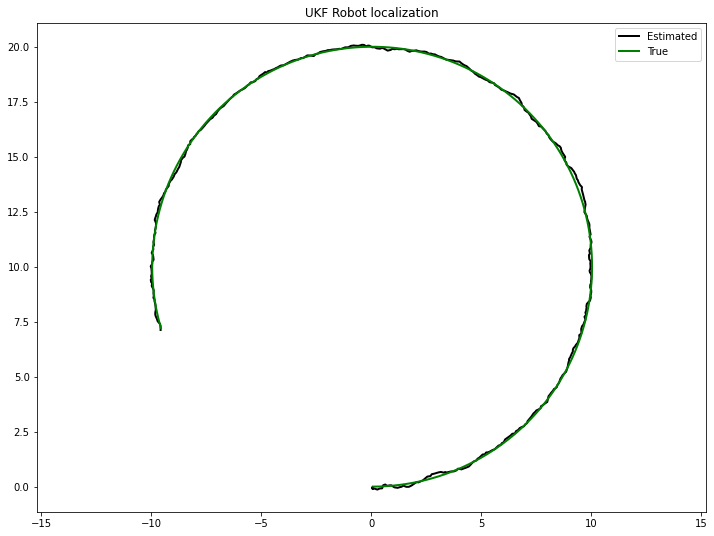

UKF standard deviation 0.050 meters


In [22]:
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

import numpy as np

dt = 0.1
sigmas = MerweScaledSigmaPoints(4, alpha=.001, beta=2., kappa=0)
ukf = UKF(dim_x=4, dim_z=2, fx=motion_model,
      hx=observation_model, dt=dt, points=sigmas)
ukf.x = np.zeros((4))

# Covariance for UKF simulation
ukf.Q = np.diag([
    0.1,  # variance of location on x-axis
    0.1,  # variance of location on y-axis
    np.deg2rad(1.0),  # variance of yaw angle
    1.0  # variance of velocity
]) ** 2  # predict state covariance
ukf.R = np.diag([1.0, 1.0]) ** 2  # Observation x,y position covariance


xTrue = np.zeros((4))
u = np.array([1, 0.1])
uxs = []
xs = []
for i in range(500):
  ukf.predict(u=u)
  xTrue, z, _ = observation(xTrue, dt, u)
  ukf.update(z)
  uxs.append(ukf.x.copy())
  xs.append(xTrue)
uxs = np.array(uxs).T
xs = np.array(xs).T

plt.figure(figsize=(12, 9))
plt.plot(uxs[0], uxs[1], color='k', lw=2, label='Estimated')
plt.plot(xs[0], xs[1], color='g', lw=2, label='True')
plt.axis('equal')
plt.title("UKF Robot localization")
plt.legend()
plt.show()

print(f'UKF standard deviation {np.std(uxs - xs):.3f} meters')